In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import lines as mlines
import os
from astropy.table import Table

## First load all the data we need into a table

We'll collate data both from a halo catalog snapshot an additionally different files storing halo history information. 

In [2]:
from read_sfh import get_scales
small_file_fname = "/Users/aphearin/Dropbox/UniverseMachine/data/histories/small_sfh_catalog_1.002310.txt"
scale_factor_array = get_scales(small_file_fname)
cosmic_age_array = np.load('/Users/aphearin/Dropbox/UniverseMachine/data/histories/prelim_sfh_reduction/times.npy')

In [3]:
from collate_full_catalog import collate_catalog
a_string = 'a_1.002310'
idx_tobs = np.where(scale_factor_array >= float(a_string[2:]))[0][0]
t_today = cosmic_age_array[idx_tobs]

history_colnames = ('halo_id', 'halo_upid', 'halo_mpeak', 'sfr_mp', 'sm_mp', 'stellar_mass', 'sfr', 
                    'a_first_infall', 'a_last_infall')

histories = collate_catalog(a_string, history_colnames=history_colnames)
print("Number of galaxies = {0}".format(len(histories)))

... Assembling history data
Number of galaxies = 676028


In [6]:
histories['time_first_acc'] = np.interp(histories['a_first_infall'], scale_factor_array, cosmic_age_array)
histories['host_mpeak'] = histories['halo_mpeak']
histories['is_quenched'] = histories['sfr']/histories['stellar_mass'] < 10**-11

satmask = (histories['gal_type'] == 'satellite') | (histories['gal_type'] == 'orphan')
sats = histories[satmask]
cenmask = histories['gal_type'] == 'central'
cens = histories[cenmask]

from halotools.utils import crossmatch
idxA, idxB = crossmatch(sats['halo_upid'], histories['halo_id'])
sats['host_mpeak'][idxA] = histories['halo_mpeak'][idxB]
histories['host_mpeak'][satmask] = sats['host_mpeak']

## SVM experimentation

In [7]:
sm_low, sm_high = 10**9.9, 10**10.1
sm_mask = (histories['stellar_mass'] >= sm_low) & ((histories['stellar_mass'] < sm_high))
sample = histories[sm_mask]
sample.write('sm_sample_temp.hdf5', path='data')

In [56]:
from pandas import DataFrame
df = DataFrame()

z_cut = 0.5
idx_last = np.searchsorted(scale_factor_array, 1./(1 + z_cut))

for isnap in range(idx_last):
    new_key = 'sfr_' + str(isnap)
    df[new_key] = sample['sfr_mp'][:, isnap]
    
    new_key = 'sm_mp_' + str(isnap)
    df[new_key] = sample['sm_mp'][:, isnap]
    
y = sample['is_quenched'].data

from sklearn.cross_validation import train_test_split
training_set_size = 5000
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=len(y)-training_set_size, random_state=43)
print("Number of galaxies in training set = {0}".format(X_train.shape[0]))

Number of galaxies in training set = 5000


In [33]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression()

from sklearn.cross_validation import cross_val_score
cross_val_score(clf, X_train, y_train, cv=3)

array([ 0.59022931,  0.57542458,  0.61938062])

In [34]:
from sklearn import svm
clf = svm.SVC(gamma=0.01, C=1., kernel='rbf')

from sklearn.cross_validation import cross_val_score
cross_val_score(clf, X_train, y_train, cv=3)

array([ 0.58524427,  0.58541459,  0.58541459])

In [53]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(class_weight='balanced', 
                             criterion='entropy', n_estimators=50)

from sklearn.cross_validation import cross_val_score
cross_val_score(clf, X_train, y_train, cv=3)

array([ 0.71656687,  0.73003992,  0.72227772])

## Loop over $M_{\ast}$ and $z$

In [57]:
import ml_performance 
reload(ml_performance)

<module 'ml_performance' from 'ml_performance.py'>

In [79]:
z_cut = 2
sm_low, sm_high = 10**9.5, 10**9.6
%timeit ml_performance.get_cross_val_score(histories, scale_factor_array, z_cut, sm_low, sm_high)

1 loop, best of 3: 2.55 s per loop


In [117]:
z_low, z_high, numz = 0.01, 3, 10
z_array = np.logspace(np.log10(z_low), np.log10(z_high), numz)

logsm_low, logsm_high, num_smbins = 9, 11.5, 10
sm_bins = np.logspace(logsm_low, logsm_high, num_smbins)

result = np.zeros((len(z_array), len(sm_bins)-1))

from itertools import product
for i, j in product(range(len(z_array)), range(len(sm_bins)-1)):
    z_cut = z_array[i]
    sm_low, sm_high = sm_bins[j], sm_bins[j+1]
    result[i, j] = ml_performance.get_cross_val_score(
        histories, scale_factor_array, z_cut, sm_low, sm_high)

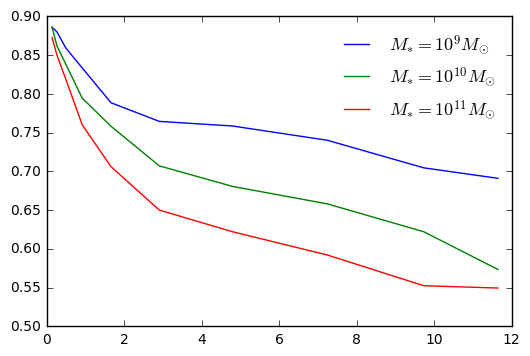

In [118]:
x = Planck13.age(0) - Planck13.age(z_array)
plt.plot(x, result[:, 0], color='blue', label=r'$ M_{\ast} = 10^{9}M_{\odot}$')
plt.plot(x, result[:, 3], color='green', label=r'$ M_{\ast} = 10^{10}M_{\odot}$')
plt.plot(x, result[:, 6], color='red', label=r'$ M_{\ast} = 10^{11}M_{\odot}$')

plt.legend(frameon=False, loc='upper right', fontsize=13)

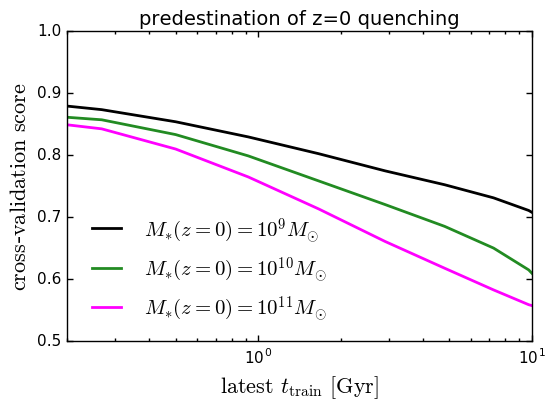

In [159]:
from scipy.signal import savgol_filter, medfilt 

x = Planck13.age(0) - Planck13.age(z_array)

fig = plt.figure()
ax = fig.add_subplot(111)

xlabel = ax.set_xlabel(r'${\rm latest}$ $t_{\rm train}$ $[{\rm Gyr}]$', fontsize=16)
ylabel = ax.set_ylabel(r'${\rm cross}$-${\rm validation}$ ${\rm score}$', fontsize=16)
title = ax.set_title('predestination of z=0 quenching', fontsize=14, y=1.) # y param fixes an overhanging title

lw=2
y1 = result[:, 0]
y1 = medfilt(y1, 3)
y1 = savgol_filter(y1, 9, 3)
ax.plot(x, y1, color='k', label=r'$ M_{\ast}(z=0) = 10^{9}M_{\odot}$', linewidth=lw)

y2 = result[:, 3]
y2 = medfilt(y2, 3)
y2 = savgol_filter(y2, 9, 3)
ax.plot(x, y2, color='forestgreen', label=r'$ M_{\ast}(z=0) = 10^{10}M_{\odot}$', linewidth=lw)

y3 = result[:, 6]
y3 = medfilt(y3, 3)
y3 = savgol_filter(y3, 9, 3)
ax.plot(x, y3, color='magenta', label=r'$ M_{\ast}(z=0) = 10^{11}M_{\odot}$', linewidth=lw)

plt.xscale('log')

plt.xlim(xmin = 2e-1, xmax=10)
plt.ylim(ymin = 0.5, ymax = 1)

plt.xticks(fontsize=11); plt.yticks(fontsize=11)
ax.tick_params(axis='x', length=4, width=1, which='major')
ax.tick_params(axis='x', length=2, width=1, which='minor')
ax.tick_params(axis='y', length=4, width=1, which='major')
ax.tick_params(axis='y', length=2, width=1, which='minor')

plt.legend(frameon=False, loc='lower left', fontsize=15)
fig.savefig('FIGS/quenching_predestination_z0.pdf', 
            bbox_extra_artists=[xlabel, ylabel], bbox_inches='tight')

In [147]:
Planck13.age(0)-Planck13.age(2)

<Quantity 10.511841788576213 Gyr>